In [2]:
import itertools

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearnex import patch_sklearn
patch_sklearn()

import sklearn

import sklearn.pipeline 
import sklearn.model_selection
import sklearn.metrics
import sklearn.neural_network

from sklearn.preprocessing import StandardScaler

import gensim.models 

from scipy import stats
import statsmodels.stats.multicomp as mc

from statannotations.Annotator import Annotator

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
mpl.rcParams.update({'xtick.labelsize': 14, 'ytick.labelsize': 14, 
                     'axes.titlesize':14, 'axes.labelsize':16}) #default font sizes for plots

In [4]:
data_dir = '/s/project/mll/sergey/effect_prediction/MLM/griesemer/'

# Combine all info together

In [5]:
expression_df = pd.read_csv(data_dir + 'paper_supplementary/Variant_MPRAu_Results.txt', sep='\t')
oligo_info_df = pd.read_csv(data_dir + 'paper_supplementary/Oligo_Variant_Info.txt', sep='\t')

In [6]:
#Add seqeunces from FASTA file

fasta_fa = data_dir + 'fasta/GRCh38_UTR_variants.fa'

seq = {}

with open(fasta_fa, 'r') as f:
    for line in f:
        if line.startswith('>'):
            oligo_id = line[1:].replace(':Homo_sapiens\n','')
            seq[oligo_id] = ''
        else:
            seq[oligo_id] += line.rstrip()

mpra_df = pd.DataFrame(seq.items(), columns=['oligo_id', 'seq'])

In [7]:
utr_variants = pd.read_csv(data_dir + '/GRCh38_UTR_variants.tsv', sep='\t')

In [8]:
#distance between variant and stop codon, different calculations for positive and negative genes

utr_variants['stop_codon_dist'] = utr_variants.apply(lambda x: x.var_start-x.human_UTR_start if x.strand=='+' else
                  x.human_UTR_end - x.var_start, axis=1) 

In [9]:
#minimal free energy from RNAfold software, recalculate each time when FASTA file changes!

mpra_df['min_free_energy'] = pd.read_csv(data_dir + 
'fasta/GRCh38_UTR_variants.free_energy.tsv', header=None).squeeze() 

In [10]:
#combine all information together

mpra_df = mpra_df.merge(oligo_info_df[['oligo_id','mpra_variant_id','ref_allele','alt_allele', 'gene_symbols','chrom', 'oligo_starts', 'oligo_ends']]).merge(expression_df).merge(utr_variants[['mpra_variant_id','stop_codon_dist']].drop_duplicates())

mpra_df.columns

Index(['oligo_id', 'seq', 'min_free_energy', 'mpra_variant_id', 'ref_allele',
       'alt_allele', 'gene_symbols', 'chrom', 'oligo_starts', 'oligo_ends',
       'log2FoldChange_Skew_HEK293FT', 'lfcSE_Skew_HEK293FT',
       'pvalue_Skew_HEK293FT', 'padj_Skew_HEK293FT',
       'log2FoldChange_Ref_HEK293FT', 'lfcSE_Ref_HEK293FT',
       'pvalue_Ref_HEK293FT', 'padj_Ref_HEK293FT',
       'log2FoldChange_Alt_HEK293FT', 'lfcSE_Alt_HEK293FT',
       'pvalue_Alt_HEK293FT', 'padj_Alt_HEK293FT', 'log2FoldChange_Skew_HEPG2',
       'lfcSE_Skew_HEPG2', 'pvalue_Skew_HEPG2', 'padj_Skew_HEPG2',
       'log2FoldChange_Ref_HEPG2', 'lfcSE_Ref_HEPG2', 'pvalue_Ref_HEPG2',
       'padj_Ref_HEPG2', 'log2FoldChange_Alt_HEPG2', 'lfcSE_Alt_HEPG2',
       'pvalue_Alt_HEPG2', 'padj_Alt_HEPG2', 'log2FoldChange_Skew_HMEC',
       'lfcSE_Skew_HMEC', 'pvalue_Skew_HMEC', 'padj_Skew_HMEC',
       'log2FoldChange_Ref_HMEC', 'lfcSE_Ref_HMEC', 'pvalue_Ref_HMEC',
       'padj_Ref_HMEC', 'log2FoldChange_Alt_HMEC', 'lfcSE_A

In [11]:
# Define Groups for Group K-fold based on genes

mpra_df['group'] = mpra_df['gene_symbols']

In [12]:
#Very few 3'UTR regions are shared between genes
#The corresponding oligos should have the same group label

df = mpra_df.sort_values(by=['chrom','oligo_starts','oligo_ends']).drop_duplicates(subset=['mpra_variant_id']).reset_index(drop=True)

df['other_mpra_variant_id'] = ''

for row_idx in range(len(df)-1):
    next_row_idx = row_idx+1
    while df.loc[row_idx].chrom==df.loc[next_row_idx].chrom and df.loc[next_row_idx].oligo_starts<df.loc[row_idx].oligo_ends:
        if df.loc[row_idx].gene_symbols != df.loc[next_row_idx].gene_symbols:
            df.loc[row_idx,'other_mpra_variant_id'] += df.loc[next_row_idx,'mpra_variant_id'] + ','
        next_row_idx+=1
        
df = df.loc[df.other_mpra_variant_id!='',['mpra_variant_id','other_mpra_variant_id']]  

for mpra_variant_id, other_mpra_variant_ids in df.values.tolist():
    for other_mpra_variant_id in other_mpra_variant_ids.rstrip(',').split(','):
        mpra_df.loc[mpra_df.mpra_variant_id==other_mpra_variant_id,'group'] = mpra_df.loc[mpra_df.mpra_variant_id==mpra_variant_id,'group'].iloc[0]

In [13]:
#mpra_df.to_csv(data_dir + 'mpra_df.tsv', index=None, sep='\t')

# Load data

In [64]:
mpra_df = pd.read_csv(data_dir + 'mpra_df.tsv', sep='\t') #sequence info

In [65]:
mlm_embeddings = np.load(data_dir + "embeddings/seq_len_5000/embeddings.npy") #masked language model embeddings

In [66]:
cell_type = 'HEK293FT' #HMEC,HEK293FT,HEPG2,K562,GM12878,SKNSH

In [67]:
#Data Cleaning
# Take only SNP mutations
# Remove nan values in Expression column

is_snp = mpra_df.ref_allele.str.len() == mpra_df.alt_allele.str.len()

flt = mpra_df[f'log2FoldChange_Skew_{cell_type}'].isna()  | (~is_snp) | (mpra_df.stop_codon_dist>5000) #| mpra_df.oligo_id.str.contains('_ref$')

mpra_df = mpra_df[~flt]
mlm_embeddings = mlm_embeddings[~flt]

In [68]:
#predict Log2FC skew between Ref and Alt alleles or just treat ref and alt seqeunces equally

predict_skew = False 

In [69]:
if predict_skew:
    mpra_df['Expression'] = mpra_df[f'log2FoldChange_Skew_{cell_type}']
    mpra_df['seqtype'] = mpra_df.apply(lambda x: 'REF' if x.oligo_id.endswith('_ref') else 'ALT',axis=1)
    assert (mpra_df.loc[mpra_df.seqtype=='REF','mpra_variant_id'].values==\
         mpra_df.loc[mpra_df.seqtype=='ALT','mpra_variant_id'].values).mean()==1
else:
    mpra_df['Expression'] = mpra_df.apply(lambda x: x[f'log2FoldChange_Alt_{cell_type}'] if x.oligo_id.endswith('_alt') else x[f'log2FoldChange_Ref_{cell_type}'], axis=1)   

In [70]:
# Conver Expression column to float

mpra_df.Expression = mpra_df.Expression.apply(lambda x:x.replace(',','.') if type(x)==str else x).astype(float)

# Compare regression algorithms

In [26]:
class GroupNestedCV():
    
    '''
    Group Nested Cross-Validation
    
    Parameters:
    clf: sklearn-compatible classifier
    hpp_search_grid: dictionary of parameter values for hyperparameter search
    
    if hpp_search_grid is None, just perform Group k-fold CV
    '''
    
    def __init__(self, clf, hpp_search_grid=None, n_splits = 10):
        
        self.clf = clf
        self.hpp_search_grid = hpp_search_grid
        self.group_kfold = sklearn.model_selection.GroupKFold(n_splits=n_splits)
        
    def run(self, X, y, groups):
    
        '''
        Iterates over  self.group_kfold folds and performs hyperparameter search within each fold

        Returns:
        Predictions for all folds
        '''

        kfold_scores = [] #predictions in all folds

        #outer loop
        for fold_idx, (train_idx, test_idx) in enumerate(self.group_kfold.split(X, y, groups)):

            X_train, y_train, groups_train = X[train_idx,:], y[train_idx], groups[train_idx]

            X_test, y_test = X[test_idx,:], y[test_idx]

            if self.hpp_search_grid!=None:

                print(f'Hyperparameter search in fold {fold_idx}')

                gs = sklearn.pipeline.make_pipeline(StandardScaler(),
                                                sklearn.model_selection.GridSearchCV(self.clf, self.hpp_search_grid, cv=3))

                gs.fit(X_train, y_train, gridsearchcv__groups = groups_train)

                best_params = gs['gridsearchcv'].best_params_
                print(f'Best hyperparameters: {best_params}')

            #train 
            pipe = sklearn.pipeline.make_pipeline(StandardScaler(), self.clf)
            pipe.fit(X_train, y_train)
            
            #inference
            y_pred = pipe.predict(X_test)

            kfold_scores.append(np.vstack(([fold_idx]*len(y_test),y_pred,y_test))) #add predictions for the current fold

        return kfold_scores

In [24]:
algs = {} #algorithms to test
hpp_search_space = {} #hyperparameter search space for each model

algs['ridge'] = sklearn.linear_model.Ridge()
hpp_search_space['ridge'] = {'alpha':10.**np.arange(-10,10)}
              
algs['MLP'] = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(64,32,16,), alpha=10, 
                 batch_size=1000, learning_rate_init=5e-4, max_iter=500, shuffle=False)

algs['SVR'] = sklearn.svm.SVR(C=4, epsilon=0.1)
#hpp_search_space['SVR'] = {'C':2.**np.arange(-5,5),'epsilon':10.**np.arange(-5,1)}


In [25]:
X = mlm_embeddings #MLM embeddings
y = mpra_df['Expression'].values #dependent variable
groups = mpra_df['group'].values #groups (genes)

In [26]:
preds_mpra = []

for model, alg in algs.items():
    
    print(f'MODEL: {model}')
    
    group_nested_cv = GroupNestedCV(alg, hpp_search_space.get(model,None), )
    
    scores = group_nested_cv.run(X, y, groups)
    
    scores = pd.DataFrame(np.hstack(scores).T, columns=['fold','y_pred','y_test']) #numpy array to DataFrame
    
    scores['model'] = model #add model column
    
    preds_mpra.append(scores)#stack dataframes of different models

preds_mpra = pd.concat(preds_mpra)#concatenate dataframes

MODEL: ridge
Hyperparameter search in fold 0
Best hyperparameters: {'alpha': 100.0}
Hyperparameter search in fold 1
Best hyperparameters: {'alpha': 100.0}
Hyperparameter search in fold 2
Best hyperparameters: {'alpha': 100.0}
Hyperparameter search in fold 3
Best hyperparameters: {'alpha': 100.0}
Hyperparameter search in fold 4
Best hyperparameters: {'alpha': 100.0}
Hyperparameter search in fold 5
Best hyperparameters: {'alpha': 100.0}
Hyperparameter search in fold 6
Best hyperparameters: {'alpha': 100.0}
Hyperparameter search in fold 7
Best hyperparameters: {'alpha': 100.0}
Hyperparameter search in fold 8
Best hyperparameters: {'alpha': 100.0}
Hyperparameter search in fold 9
Best hyperparameters: {'alpha': 100.0}
MODEL: MLP
MODEL: SVR


In [27]:
preds_mpra

,fold,y_pred,y_test,model
0,0.0,-0.526315,0.101798,ridge
1,0.0,-0.475818,-0.237751,ridge
2,0.0,-0.461430,-0.183660,ridge
3,0.0,-0.525686,-0.475822,ridge
4,0.0,0.191575,0.693005,ridge
...,...,...,...,...
14965,9.0,-0.181854,-0.798085,SVR
14966,9.0,0.074127,0.029363,SVR
14967,9.0,0.019421,0.225314,SVR
14968,9.0,0.064456,-0.209163,SVR


In [28]:
per_fold_scores = preds_mpra.groupby(['model','fold']).apply(lambda x: sklearn.metrics.r2_score(x.y_test,x.y_pred)).rename('score').reset_index()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MLP vs. SVR: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:2.754e-01 Stat=1.600e+01
SVR vs. ridge: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:1.953e-03 Stat=0.000e+00
MLP vs. ridge: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:6.445e-02 Stat=9.000e+00


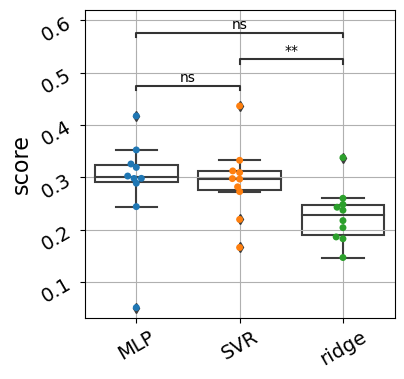

In [29]:
fig, ax = plt.subplots(figsize=(4,4))

ax = sns.swarmplot(data=per_fold_scores, x="model", y="score") #scatter plot
ax = sns.boxplot(data=per_fold_scores, x="model", y="score", boxprops={'facecolor':'None'})

box_pairs=[ ("MLP", "SVR"), ("MLP", "ridge"), ("SVR", 'ridge')]

annotator = Annotator(ax, box_pairs, data=per_fold_scores, x="model", y="score")
annotator.configure(test='Wilcoxon', text_format='star', loc='inside', comparisons_correction="BH")
#annotator.configure(test='t-test_paired', text_format='star', loc='inside', comparisons_correction="BH")

annotator.apply_and_annotate()

ax.set_xlabel("")
ax.set_ylabel("score")
ax.tick_params(rotation=30)
ax.grid()

# Comparing with other embeddings

In [71]:
class Kmerizer:
    '''
    Helper class to generate k-mers and Word2Vec embeddings
    '''
    
    def __init__(self, k):
        
        self.k = k
        
        #generate all possible k-mers, e.g. 
        self.kmers = {"".join(x):i for i,x in zip(range(4**k), itertools.product("ACGT",repeat=k))} 
        
    def kmerize(self, seq):
        '''
        Count all k-mers in the sequence 
        Returns:
        A list with counts corresponding to each possible k-mer from self.kmers
        e.g. for k=2 and seq='ACTAC'
        > [0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0]
        '''
        counts = [0]*4**self.k
        for i in range(len(seq) - self.k + 1): 
            kmer = seq[i:i+self.k]
            counts[self.kmers[kmer]] += 1
        return counts
    
    def tokenize(self, seq):
        '''
        Get all k-mers in the sequence
        Returns:
        A list of all k-mers
        e.g. for 2-mers and seq='ACTAC' 
        > ['AC', 'CT', 'TA', 'AC']
        '''
        kmers = []
        for i in range(len(seq) - self.k + 1): 
            kmer = seq[i:i+self.k]
            kmers.append(kmer)
        return kmers

In [72]:
def word2vec_model(mpra_df):
    
    '''
    Word2Vec model
    
    k-mers are defined through their context: 
    k-mers with similar context will have similar embeddings
    '''
    
    kmerizer_w2v = Kmerizer(k=4)
    
    w2v_model = gensim.models.Word2Vec(sentences=mpra_df.seq.apply(lambda x: kmerizer_w2v.tokenize(x)), 
                         vector_size=128, window=5, min_count=1, workers=4, sg=1) #default: CBOW

    word2vec_emb = mpra_df.seq.apply(
        lambda x: np.mean([w2v_model.wv[x]  for x in kmerizer_w2v.tokenize(x)],axis=0)) #average embedding of all 4-mers in the sequence

    X = np.stack(word2vec_emb,axis=0)
    
    return X

In [73]:
def minseq_model(mpra_df):
    
    '''
    Minimal sequence model from Griesemer et al. 2021
    
    Extracts following features from mpra_df:
    --nucleotide counts for each base (+4) and maximum among them (+1)
    --dinucleotide counts (+16) and maximum among them (+1)
    --maximum homopolymer length for all bases (+4)
    --maximum dinucleotide repeat length length for all bases (+16)
    --sequence uniformity (+1)
    --Minimal free energy (from RNA fold Software) (+1)
    
    Returns:
    Feature matrix X
    '''
    
    kmerizer1 = Kmerizer(k=1)

    nucl_counts = np.stack(mpra_df.seq.apply(lambda seq: kmerizer1.kmerize(seq)))
    max_nucl_counts_all = nucl_counts.max(axis=1)

    kmerizer2 = Kmerizer(k=2)

    dinucl_counts = np.stack(mpra_df.seq.apply(lambda seq: kmerizer2.kmerize(seq)))
    max_dinucl_counts_all = dinucl_counts.max(axis=1)
    
    max_homopol_len = np.stack(mpra_df.seq.apply(lambda seq: max_repeat_length(seq,1)))
    max_dinucl_len = np.stack(mpra_df.seq.apply(lambda seq: max_repeat_length(seq,2)))

    seq_uniformity = mpra_df.seq.apply(lambda seq: np.sum([seq[i]==seq[i-1] for i in range(1,len(seq))])).values
    #min_free_energy = mpra_df['min_free_energy'].values
    
    X = np.hstack((nucl_counts,np.expand_dims(max_nucl_counts_all,axis=1),
           dinucl_counts,np.expand_dims(max_dinucl_counts_all,axis=1),
           max_homopol_len, max_dinucl_len,
           np.expand_dims(seq_uniformity,axis=1),
           ))
    
    return X

def max_repeat_length(seq,k):
    
    '''
    Get repeat lengths of all k-mers in sequence
    Returns:
    Array of maximal repeat lengths for all k-mers
    '''

    max_subseq_length = {"".join(x):0 for x in itertools.product("ACGT",repeat=k)}

    for start in range(k):
        n_repeats=1 #each subsequence has at least 1 repeat
        for seq_idx in range(start,len(seq)-k+1,k):
            subseq = seq[seq_idx:seq_idx+k] #current subsequence
            if subseq==seq[seq_idx+k:seq_idx+2*k]: #if repeated at the next position
                n_repeats+=1 #increase repeats counter
            else:
                max_subseq_length[subseq] = max(max_subseq_length[subseq],n_repeats) #is the current subseq repeat longer?
                n_repeats = 1 #reinitialize repeats counter
                
        max_subseq_length[subseq] = max(max_subseq_length[subseq],n_repeats) #end of the sequence
       
    repeat_length = np.array(list(max_subseq_length.values()))
    
    return repeat_length

In [74]:
data_matrices = {} #embeddings dictionary

data_matrices['MLM'] = mlm_embeddings

kmerizer4 = Kmerizer(k=4)
data_matrices['4-mers'] = np.stack(mpra_df.seq.apply(lambda x: kmerizer4.kmerize(x))) 

data_matrices['Word2Vec'] = word2vec_model(mpra_df)

data_matrices['Griesemer et al.'] = minseq_model(mpra_df)

for model in data_matrices:
    data_matrices[model] = np.hstack((data_matrices[model],np.expand_dims(mpra_df.min_free_energy.values,axis=1)))

y = mpra_df['Expression'].values
groups = mpra_df['group'].values

In [ ]:
#alg = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(64,32,16,), alpha=10, 
#                 batch_size=1000, learning_rate_init=5e-4, max_iter=500, shuffle=False)

hpp_dict = {'MLM':{'C':4}, '4-mers':{'C':1},
                    'Word2Vec':{'C':1},'Griesemer et al.':{'C':1}}
    
preds_mpra = []

for model, X in data_matrices.items():
    
    print(f'MODEL: {model}')
    
    alg = sklearn.svm.SVR(epsilon=0.1, **hpp_dict[model], cache_size=2000)
    
    group_nested_cv = GroupNestedCV(alg, )
    
    scores = group_nested_cv.run(X, y, groups)
    
    scores = pd.DataFrame(np.hstack(scores).T, columns=['fold','y_pred','y_test']) #numpy array to DataFrame
    
    scores['model'] = model #add model column
    
    preds_mpra.append(scores)#stack dataframes of different models

preds_mpra = pd.concat(preds_mpra)

MODEL: MLM
MODEL: 4-mers
MODEL: Word2Vec


In [ ]:
per_fold_scores = preds_mpra.groupby(['model','fold']).apply(lambda x: sklearn.metrics.r2_score(x.y_test,x.y_pred)).rename('score').reset_index()

In [ ]:
fig, ax = plt.subplots(figsize=(4,4))

ax = sns.swarmplot(data=per_fold_scores, x="model", y="score") #scatter plot
ax = sns.boxplot(data=per_fold_scores, x="model", y="score", boxprops={'facecolor':'None'})

box_pairs=[ ("MLM", "4-mers"), ("MLM", "Word2Vec"), ("MLM", "Griesemer et al.")]

annotator = Annotator(ax, box_pairs, data=per_fold_scores, x="model", y="score")
annotator.configure(test='Wilcoxon', text_format='star', loc='inside', comparisons_correction="BH")
#annotator.configure(test='t-test_paired', text_format='star', loc='inside', comparisons_correction="BH")

annotator.apply_and_annotate()

ax.set_xlabel("")
ax.set_ylabel("score")
ax.tick_params(rotation=30)
ax.grid()

# Assessing model stability

In [30]:
model = 'Griesemer et al.'

X = data_matrices[model]
y = mpra_df['Expression'].values
groups = mpra_df['group'].values

pipe = sklearn.pipeline.make_pipeline(sklearn.preprocessing.StandardScaler(), 
                     sklearn.linear_model.Ridge(alpha=100)) 

#pipe = sklearn.pipeline.make_pipeline(sklearn.preprocessing.StandardScaler(), 
#                     sklearn.svm.SVR(C=4, epsilon=0.1))

#pipe = sklearn.pipeline.make_pipeline(sklearn.preprocessing.StandardScaler(), 
#                sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(64,32,16,), alpha=10, batch_size=1000, learning_rate_init=5e-4, max_iter=500, shuffle=False))

N_rounds = 25 #number of CV rounds
N_splits = 10 #number of CV splits in each round

N_instances = len(y) #total number of test points equals dataset size

cv_res = np.zeros((N_rounds*N_splits,N_instances)) #CV predictions for each point
cv_res[:] = np.NaN 

cv_scores = [] # score for each fold in each round, N_rounds X N_splits

for round_idx in range(N_rounds):
    
    print(f'CV round {round_idx}')

    gss = sklearn.model_selection.GroupShuffleSplit(n_splits=N_splits, train_size=.9, random_state = round_idx) #10-fold CV

    for fold_idx, (train_idx, test_idx) in enumerate(gss.split(X, y, groups)):
        
        X_train, X_test, y_train, y_test = X[train_idx,:],X[test_idx,:],y[train_idx],y[test_idx]
        
        pipe.fit(X_train,y_train)
        
        y_pred = pipe.predict(X_test)
            
        cv_res[round_idx*N_splits+fold_idx,test_idx] = y_pred #predictions for test instances in this fold in this round
        
        cv_scores.append((sklearn.metrics.r2_score(y_test,y_pred), round_idx)) #score for this fold in this round
        
cv_scores = pd.DataFrame(cv_scores, columns=['score', 'CV round'])

CV round 0
CV round 1
CV round 2
CV round 3
CV round 4
CV round 5
CV round 6
CV round 7
CV round 8
CV round 9
CV round 10
CV round 11
CV round 12
CV round 13
CV round 14
CV round 15
CV round 16
CV round 17
CV round 18
CV round 19
CV round 20
CV round 21
CV round 22
CV round 23
CV round 24


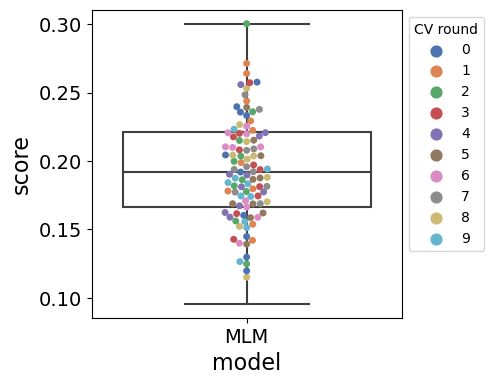

In [31]:
fig, ax = plt.subplots(figsize=(4,4))

cv_scores['model'] = model

ax = sns.swarmplot(data=cv_scores[cv_scores['CV round']<10],y='score',x='model',hue="CV round", palette="deep")
ax = sns.boxplot(data=cv_scores,y='score',x='model', boxprops={'facecolor':'None'})
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

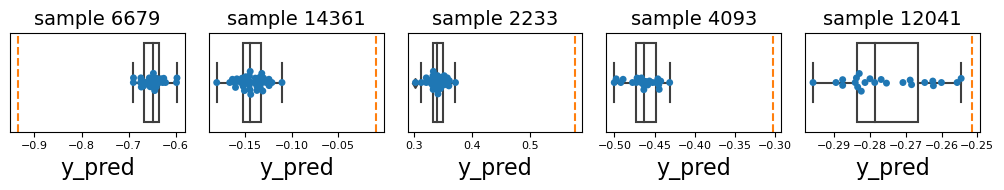

In [32]:
fig, axes = plt.subplots(1,5, figsize=(10,2))

axes = axes.flatten()

samples = np.random.choice(a=range(len(y)),size=5) #choose 5 random test points

for ax,sample_idx in zip(axes,samples):
    #sns.kdeplot(x=cv_res[:,sample_idx], ax=ax)
    sns.swarmplot(x=cv_res[:,sample_idx], ax=ax)
    sns.boxplot(x=cv_res[:,sample_idx], ax=ax, boxprops={'facecolor':'None'})
    ax.set_ylabel('')
    ax.set_yticks([])
    ax.tick_params(axis='x', which='major', labelsize=8)
    ylims = ax.get_ylim()
    ax.plot(y[sample_idx]*np.ones((50,)),np.linspace(*ylims), linestyle='--', color='tab:orange') #y_true
    ax.set_title(f'sample {sample_idx}')
    ax.set_xlabel('y_pred')
    
fig.tight_layout()

In [33]:
cv = np.nanstd(cv_res,axis=0)/np.nanmean(cv_res,axis=0) #coefficient of variation of each test point due to change in train set distribution

In [34]:
abs(cv).mean() #measure of model instability

0.3412219127820592

In [76]:
score_per_round = cv_scores.groupby('CV round')['score'].mean()#mean score in each round

CV_rounds = np.arange(1,N_rounds+1)

average_score = np.cumsum(score_per_round)/CV_rounds #cumulative average

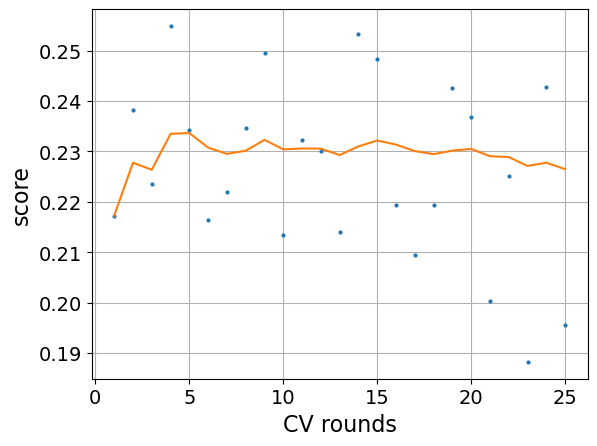

In [77]:
fig, ax = plt.subplots()

ax.plot(CV_rounds, score_per_round, marker='o', markersize=2, linestyle='') 

ax.plot(CV_rounds, average_score, markersize=2) 

ax.set_xlabel('CV rounds')
ax.set_ylabel('score')
ax.grid()